# Method Stability

In this notebook we evaluate 2 modes of stability of our method.

1. Given that our neural network to find facial landmarks has a mean error of around 4mm, how much impact does this have on the location of Kocher's Point?
2. Given that Kocher's point moves around a bit, based on the landmarks, how much does this affect the location of the Target Point?

In [1]:
from itertools import product
from pathlib import Path
from typing import Any

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

from evdplanner.cli import set_verbosity
from evdplanner.generation import measure_kocher, find_closest_intersection
from evdplanner.geometry import Mesh
from evdplanner.linalg import Vec3
from evdplanner.markups import DisplaySettings, MarkupManager
from evdplanner.rendering import find_target

skin_mesh_file = "mesh_skin.stl"
ventricles_mesh_file = "mesh_ventricles.stl"

manual_landmarks_file = "landmarks_skin.mrk.json"
predicted_landmarks_file = "landmarks_skin_predicted.mrk.json"

evd_file = "EVD.mrk.json"

samples_dir = Path(r"S:\E_ResearchData\evdplanner\Samples")
test_dir = Path(r"S:\E_ResearchData\evdplanner\Test")

scores_file = Path(r"S:\E_ResearchData\evdplanner\MajorityVoting.csv")

set_verbosity(0)


In [2]:
patients = [x.resolve() for x in test_dir.iterdir() if x.is_dir()]

In [3]:
records = []

check_radially = True
radius = 1.5
objective_distance_weight = 0.75
thickness_threshold = 10.0
depth_threshold = 80.0

for idx, patient in enumerate(patients):
    print(f"Processing patient {patient.name} ({idx + 1}/{len(patients)})...")

    left_record = {
        "Patient": patient.name,
        "Side": "Left",
    }
    right_record = {
        "Patient": patient.name,
        "Side": "Right",
    }

    try:
        skin_mesh = Mesh.load(str(patient / skin_mesh_file))
        gt_landmarks = MarkupManager.load(patient / manual_landmarks_file)
        predicted_landmarks = MarkupManager.load(patient / predicted_landmarks_file)
    except:
        print(f"Skin Mesh or landmarks not found for patient {patient.name}.")
        continue
    
    gt_nasion = Vec3(*gt_landmarks.find_fiducial("Nasion").position)
    gt_left_ear = Vec3(*gt_landmarks.find_fiducial("Pre-Auricle Left").position)
    gt_right_ear = Vec3(*gt_landmarks.find_fiducial("Pre-Auricle Right").position)

    predicted_nasion = Vec3(*predicted_landmarks.find_fiducial("Nasion").position)
    predicted_left_ear = Vec3(*predicted_landmarks.find_fiducial("Pre-Auricle Left").position)
    predicted_right_ear = Vec3(*predicted_landmarks.find_fiducial("Pre-Auricle Right").position)

    left_record["N Error"] = (predicted_nasion - gt_nasion).length
    right_record["N Error"] = (predicted_nasion - gt_nasion).length
    left_record["LPA Error"] = (predicted_left_ear - gt_left_ear).length
    right_record["LPA Error"] = (predicted_left_ear - gt_left_ear).length
    left_record["RPA Error"] = (predicted_right_ear - gt_right_ear).length
    right_record["RPA Error"] = (predicted_right_ear - gt_right_ear).length

    print("Measuring Kocher's points...")
    gt_left_kp, gt_right_kp = measure_kocher(
        mesh=skin_mesh,
        nasion=gt_nasion,
        left_ear=gt_left_ear,
        right_ear=gt_right_ear,
    )
    predicted_left_kp, predicted_right_kp = measure_kocher(
        mesh=skin_mesh,
        nasion=predicted_nasion,
        left_ear=predicted_left_ear,
        right_ear=predicted_right_ear,
    )

    left_record[r"$K$ Difference"] = (predicted_left_kp - gt_left_kp).length
    right_record[r"$K$ Difference"] = (predicted_right_kp - gt_right_kp).length

    print("Finding target...")
    try:
        ventricles_mesh = Mesh.load(str(patient / ventricles_mesh_file))

        gt_left_tp, _ = find_target(
            ventricles_mesh,
            gt_left_kp,
            check_radially=check_radially,
            radius=radius,
            objective_distance_weight=objective_distance_weight,
            thickness_threshold=thickness_threshold,
            depth_threshold=depth_threshold,
        )
        gt_right_tp, _ = find_target(
            ventricles_mesh,
            gt_right_kp,
            check_radially=check_radially,
            radius=radius,
            objective_distance_weight=objective_distance_weight,
            thickness_threshold=thickness_threshold,
            depth_threshold=depth_threshold,
        )

        pred_left_tp, _ = find_target(
            ventricles_mesh,
            predicted_left_kp,
            check_radially=check_radially,
            radius=radius,
            objective_distance_weight=objective_distance_weight,
            thickness_threshold=thickness_threshold,
            depth_threshold=depth_threshold,
        )
        pred_right_tp, _ = find_target(
            ventricles_mesh,
            predicted_right_kp,
            check_radially=check_radially,
            radius=radius,
            objective_distance_weight=objective_distance_weight,
            thickness_threshold=thickness_threshold,
            depth_threshold=depth_threshold,
        )

        left_record[r"$T$ Difference"] = (pred_left_tp - gt_left_tp).length
        right_record[r"$T$ Difference"] = (pred_right_tp - gt_right_tp).length
    except:
        print(f"Ventricles mesh not found for patient {patient.name}.")
        continue

    records.extend([left_record, right_record])

Processing patient Pierre 263783 (1/53)...
Measuring Kocher's points...
Finding target...
Processing patient Pierre 344382 (2/53)...
Measuring Kocher's points...
Finding target...
Processing patient Augmedit SAH_USZ 05500 (3/53)...
Measuring Kocher's points...
Finding target...
Processing patient Augmedit Other CTA_4 (4/53)...
Measuring Kocher's points...
Finding target...
Processing patient Augmedit SAH_USZ 11402 (5/53)...
Measuring Kocher's points...
Finding target...
Processing patient Augmedit SAH_USZ 13100 (6/53)...
Measuring Kocher's points...
Finding target...
Processing patient Pierre 208153 (7/53)...
Measuring Kocher's points...
Finding target...
Processing patient Augmedit SAH_USZ 08800 (8/53)...
Measuring Kocher's points...
Finding target...
Processing patient Pierre 294313 (9/53)...
Measuring Kocher's points...
Finding target...
Processing patient Augmedit SAH_USZ 01700 (10/53)...
Measuring Kocher's points...
Finding target...
Processing patient Thor 195 (11/53)...
Measurin

In [4]:
df = pd.DataFrame.from_records(records)
df.head()

,Patient,Side,N Error,LPA Error,RPA Error,$K$ Difference,$T$ Difference
0,Pierre 263783,Left,2.898877,10.479988,5.262698,2.048950,1.313673
1,Pierre 263783,Right,2.898877,10.479988,5.262698,1.906464,0.602590
2,Pierre 344382,Left,0.908155,2.419126,3.942651,3.704439,0.287658
3,Pierre 344382,Right,0.908155,2.419126,3.942651,3.931049,2.184420
4,Augmedit SAH_USZ 05500,Left,1.525027,6.563975,7.397219,1.248294,0.257479


In [5]:
scores = pd.read_csv(scores_file)
scores = scores.rename(columns={"PatientID": "Patient", "Score": "Kakarla"})
df = df.merge(scores, on=["Patient", "Side"], how="left")
df.head()

,Patient,Side,N Error,LPA Error,RPA Error,$K$ Difference,$T$ Difference,Modality,Kakarla
0,Pierre 263783,Left,2.898877,10.479988,5.262698,2.048950,1.313673,MRI,1
1,Pierre 263783,Right,2.898877,10.479988,5.262698,1.906464,0.602590,MRI,1
2,Pierre 344382,Left,0.908155,2.419126,3.942651,3.704439,0.287658,MRI,3
3,Pierre 344382,Right,0.908155,2.419126,3.942651,3.931049,2.184420,MRI,1
4,Augmedit SAH_USZ 05500,Left,1.525027,6.563975,7.397219,1.248294,0.257479,CT,1


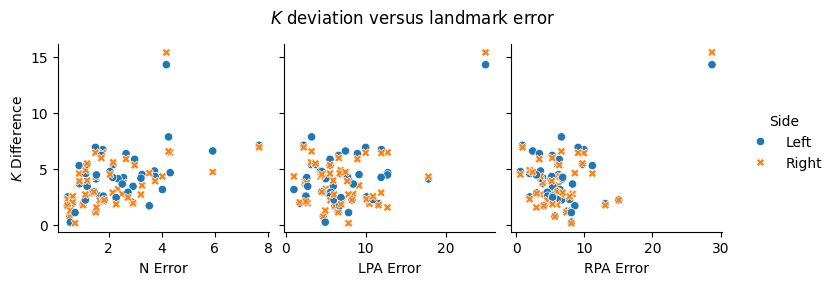

In [6]:
p = sns.pairplot(
    data=df,
    hue="Side",
    markers=["o", "X"],
    diag_kind=None,
    x_vars=[
        "N Error",
        "LPA Error",
        "RPA Error",
    ],
    y_vars=[
        r"$K$ Difference",
    ],
)

p.figure.suptitle(r"$K$ deviation versus landmark error", y=1.1)

plt.show()

Pearson correlation between N Error and $K$ Difference: 0.50 (p-value: 1.97e-07)
Pearson correlation between LPA Error and $K$ Difference: 0.41 (p-value: 3.19e-05)
Pearson correlation between RPA Error and $K$ Difference: 0.43 (p-value: 1.22e-05)
Pearson correlation between $K$ Difference and $T$ Difference: 0.17 (p-value: 9.79e-02)


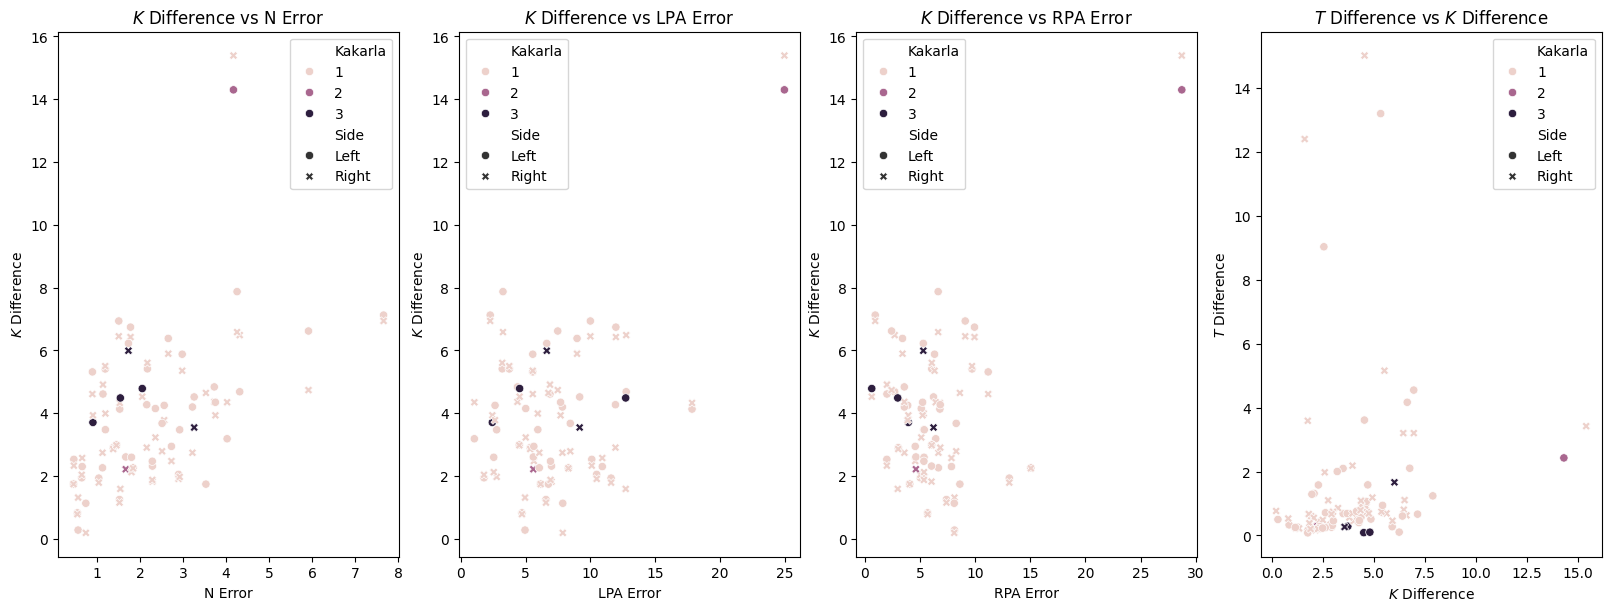

In [7]:
pairs = [
    ("N Error", r"$K$ Difference"),
    ("LPA Error", r"$K$ Difference"),
    ("RPA Error", r"$K$ Difference"),
    (r"$K$ Difference", r"$T$ Difference"),
]

fig, axs = plt.subplots(
    nrows=1,
    ncols=len(pairs),
    figsize=(16, 6),
    constrained_layout=True,
)

for ax, (x, y) in zip(axs, pairs):
    # Calculate Pearson correlation coefficient
    corr, p = pearsonr(df[x], df[y])
    print(f"Pearson correlation between {x} and {y}: {corr:.2f} (p-value: {p:.2e})")

    p = sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue="Kakarla",
        style="Side",
        ax=ax,
    )
    p.set_title(f"{y} vs {x}")
    p.set_xlabel(x)
    p.set_ylabel(y)


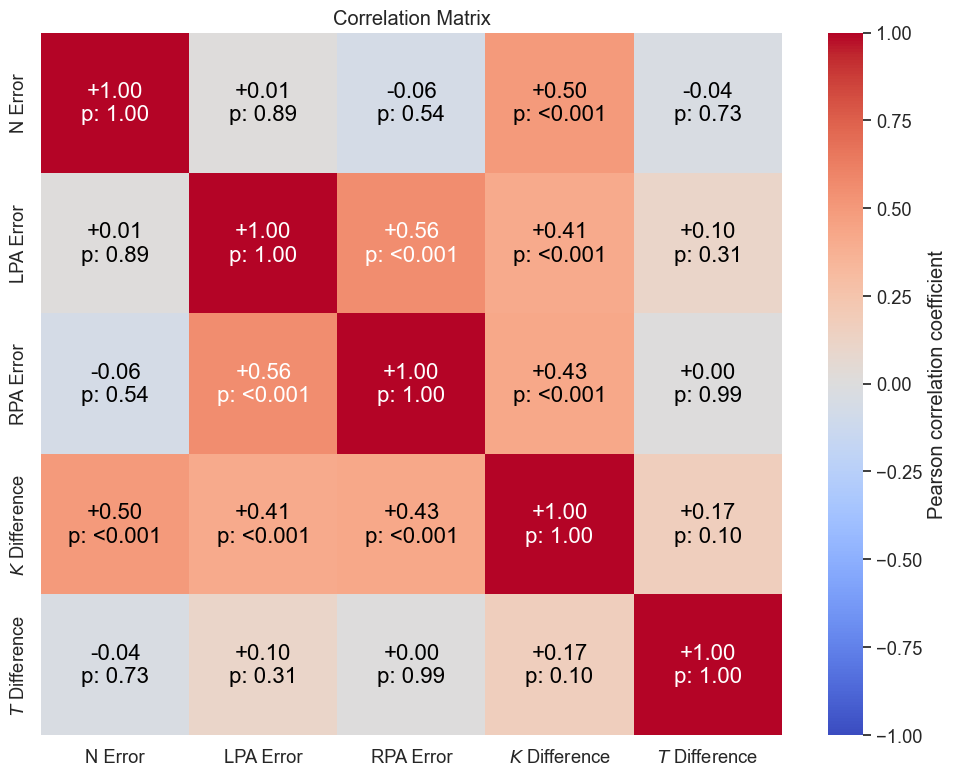

In [8]:
selected_columns = ["N Error", "LPA Error", "RPA Error", r"$K$ Difference", r"$T$ Difference"]

correlations = df[selected_columns].corr(method="pearson")
p_values = df[selected_columns].corr(method=lambda x, y: pearsonr(x, y)[1])
mask = np.triu(np.ones_like(correlations, dtype=bool))

sns.set_style("white")
sns.set_context("notebook", font_scale=1.2)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    correlations,
    # mask=mask,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={"label": "Pearson correlation coefficient"},
    vmin=-1,
    vmax=1,
    center=0,
    ax=ax,
)

for i in range(correlations.shape[0]):
    for j in range(correlations.shape[1]):
        # if i >= j:
        #     continue

        corr = f"{correlations.iloc[i, j]:.2f}"
        if correlations.iloc[i, j] > 0:
            corr = f"+{corr}"
        else:
            corr = f"{corr}"
        if p_values.iloc[i, j] < 0.001:
            p_val = "<0.001"
        elif p_values.iloc[i, j] < 0.01:
            p_val = f"{p_values.iloc[i, j]:.2e}"
        else:
            p_val = f"{p_values.iloc[i, j]:.2f}"

        color = "black" if abs(correlations.iloc[i, j]) < 0.5 else "white"

        ax.text(
            i + 0.5,
            j + 0.5,
            f"{corr}\np: {p_val}",
            ha="center",
            va="center",
            color=color,
            fontsize=16,
        )

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [10]:
# mean and std of the errors
for col in selected_columns:
    mean = df[col].mean()
    std = df[col].std()
    median = df[col].median()
    low_ci = df[col].quantile(0.025)
    high_ci = df[col].quantile(0.975)
    print(f"{col}: {mean:.2f} ± {std:.2f} (median: {median:.2f}, 95% CI: [{low_ci:.2f}, {high_ci:.2f}])")

N Error: 2.24 ± 1.45 (median: 1.84, 95% CI: [0.46, 5.92])
LPA Error: 7.17 ± 4.27 (median: 6.56, 95% CI: [1.78, 17.85])
RPA Error: 6.34 ± 4.32 (median: 5.39, 95% CI: [0.94, 15.06])
$K$ Difference: 3.88 ± 2.37 (median: 3.61, 95% CI: [0.80, 7.55])
$T$ Difference: 1.43 ± 2.53 (median: 0.68, 95% CI: [0.10, 10.98])
